<h1 style="font-family : Arial; background-color : rgb(255,102,0); color : white; border : 2px solid; text-align:center; padding-top : 20px; padding-bottom:20px">FORECASTING INCOMMING CALLS</h1>

In [148]:
import pandas as pd
import numpy as np
import os
folder_path = r'C:\Users\sst\Downloads\Time series\data_base'
files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]
all_data = pd.DataFrame()
for file in files :
    file_path = os.path.join(folder_path, file)
    data = pd.read_excel(file_path)
    all_data = pd.concat([all_data, data], ignore_index=True)

In [149]:
all_data.head()

,upd_dt,tranche_30mn,programme,type_client,nb_appel_recu_file_attente,nb_appel_fermeture,nb_appel_sorti_erreur,nb_abandon_file_attente,nb_abandon_prompt,nbrepondu_0_10s,nbrepondu_0_20s,nbrepondu_0_30s,nbrepondu_0_40s,nbrepondu_0_50s,nbrepondu_0_60s,nbrepondu_plus_60s,nb_appel_traite_agent
0,2022-01-01,[00:00-00:30[,AOM,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-01-01,[00:30-01:00[,AOM,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-01-01,[01:00-01:30[,AOM,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-01-01,[01:30-02:00[,AOM,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-01-01,[02:00-02:30[,AOM,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0


In [150]:
df = all_data.copy()
df = df.set_index('upd_dt')
df.index = pd.to_datetime(df.index)
df = df[['tranche_30mn','programme','nb_appel_recu_file_attente']]
df.head()

,tranche_30mn,programme,nb_appel_recu_file_attente
upd_dt,,,
2022-01-01,[00:00-00:30[,AOM,0
2022-01-01,[00:30-01:00[,AOM,0
2022-01-01,[01:00-01:30[,AOM,0
2022-01-01,[01:30-02:00[,AOM,0
2022-01-01,[02:00-02:30[,AOM,0


In [151]:
gp = df[df['programme']=='Particulier GP']
gp = gp[['tranche_30mn','nb_appel_recu_file_attente']]
gp = gp.resample('D').sum(numeric_only=True)
gp_fin = gp.index.max()
gp_debut = gp_fin - pd.DateOffset(days=62)
gp_8 = gp[(gp.index >= gp_debut) & (gp.index <= gp_fin)]
gp_cv = gp_8[gp_8.index >= gp_fin - pd.DateOffset(days=6)]  
gp_train = gp_8[gp_8.index <= gp_fin - pd.DateOffset(days=7)] 

In [174]:
gp_train.transpose()

upd_dt,2024-04-29,2024-04-30,2024-05-01,2024-05-02,2024-05-03,2024-05-04,2024-05-05,2024-05-06,2024-05-07,2024-05-08,...,2024-06-14,2024-06-15,2024-06-16,2024-06-17,2024-06-18,2024-06-19,2024-06-20,2024-06-21,2024-06-22,2024-06-23
nb_appel_recu_file_attente,887,887,668,801,819,661,406,910,845,835,...,732,689,341,896,827,865,1067,905,844,330


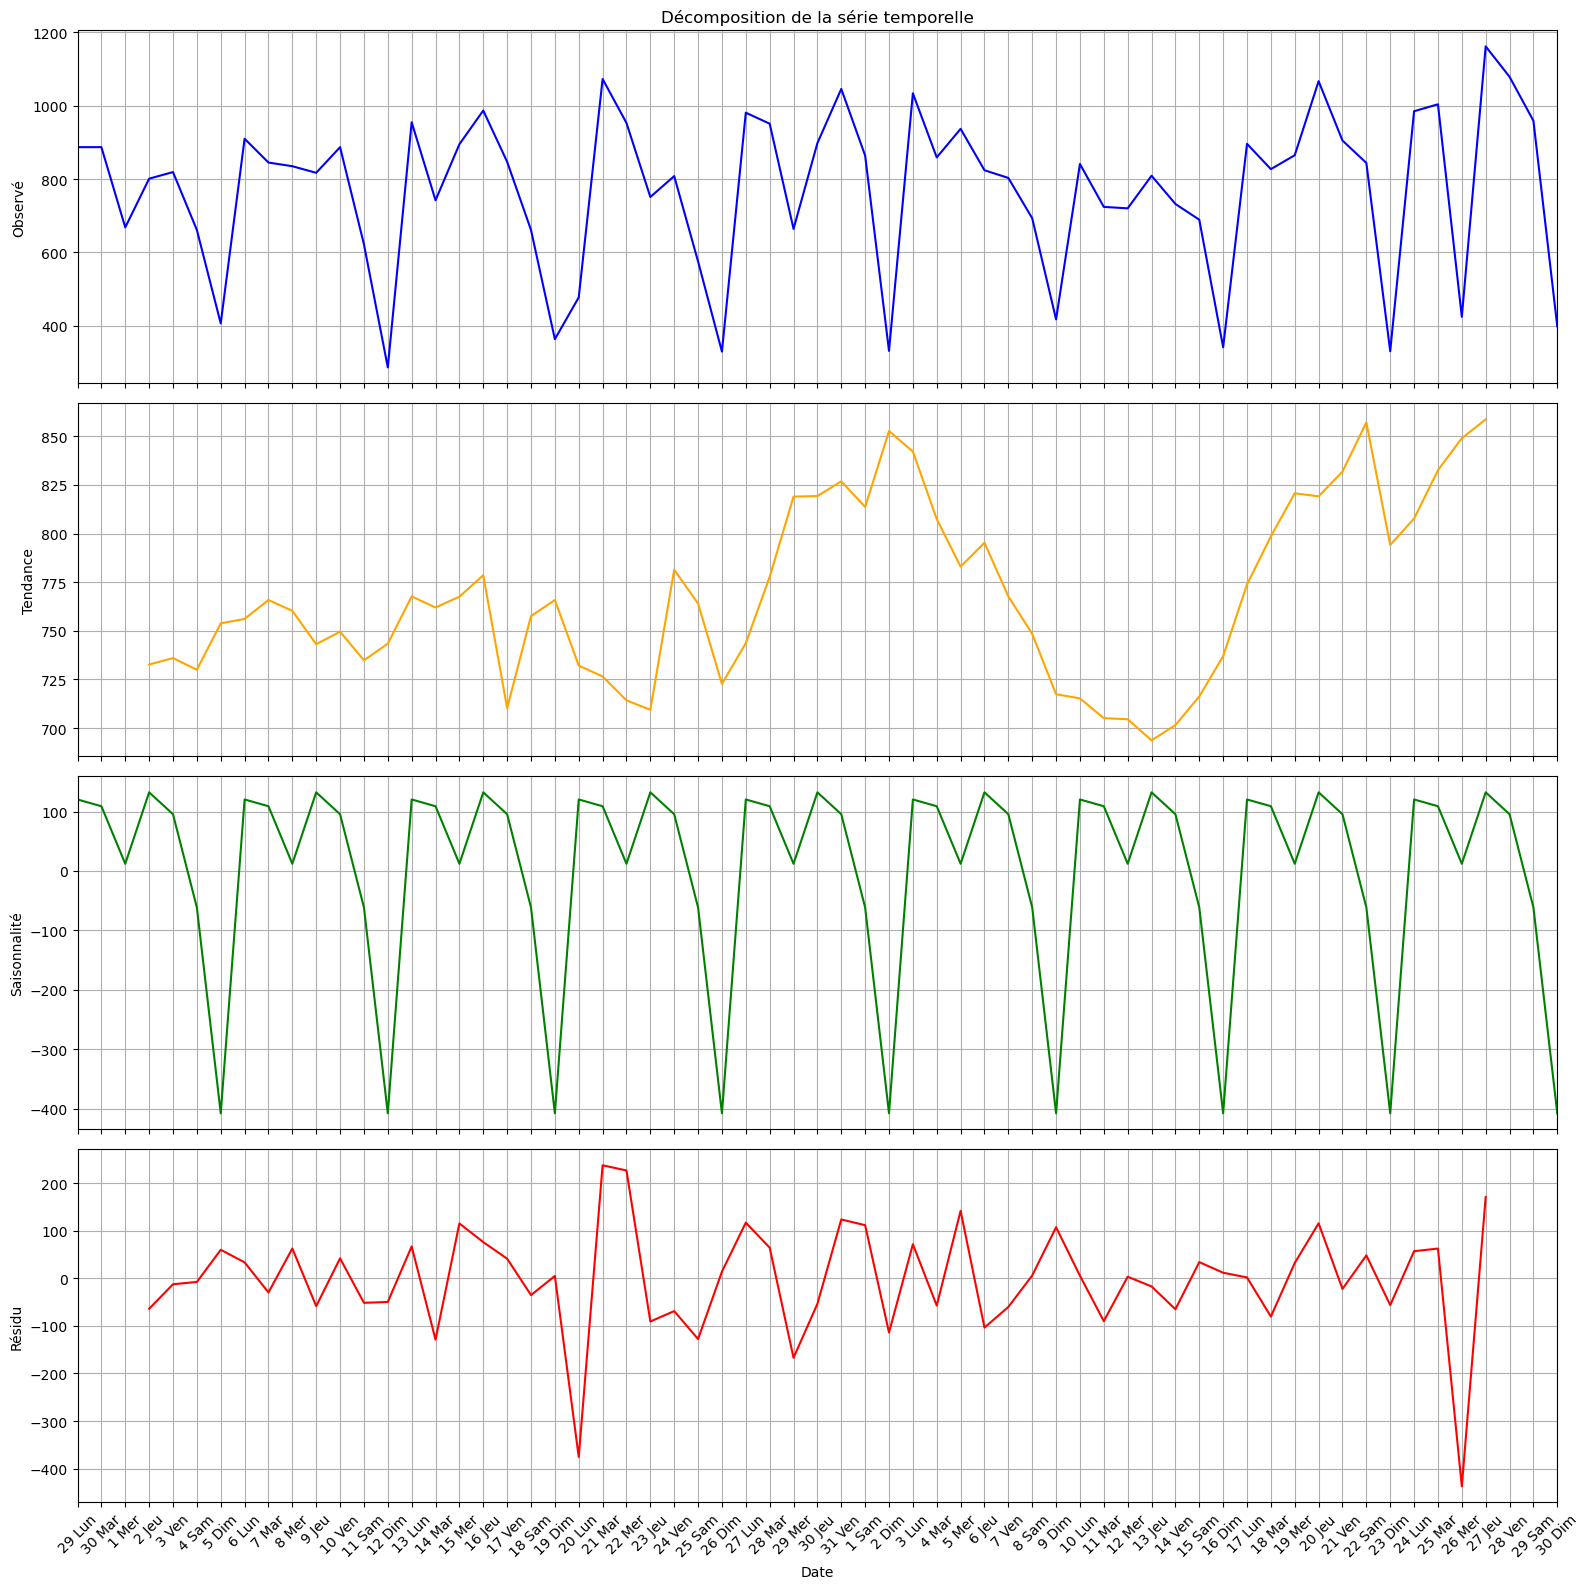

In [153]:
# Décomposition de la série temporelle
from statsmodels.tsa.seasonal import seasonal_decompose

y = gp_8.copy()

decomposition = seasonal_decompose(y, model='additive')

# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(4, 1, figsize=(16, 16), sharex=True)

# Plot des composants
decomposition.observed.plot(ax=axs[0], color='blue')
axs[0].set_ylabel('Observé')
axs[0].set_title('Décomposition de la série temporelle')
axs[0].grid(True)

decomposition.trend.plot(ax=axs[1], color='orange')
axs[1].set_ylabel('Tendance')
axs[1].grid(True)

decomposition.seasonal.plot(ax=axs[2], color='green')
axs[2].set_ylabel('Saisonnalité')
axs[2].grid(True)

decomposition.resid.plot(ax=axs[3], color='red')
axs[3].set_ylabel('Résidu')
axs[3].set_xlabel('Date')
axs[3].grid(True)

# Formatage des étiquettes de l'axe des x pour afficher les jours de la semaine
def format_date_labels(ax, dates):
    # Obtenir les jours de la semaine
    day_names = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
    # Ajouter une colonne pour les jours de la semaine dans les labels
    labels = [f"{date.day} {day_names[date.weekday()]}" for date in dates]
    ax.set_xticks(dates)
    ax.set_xticklabels(labels, rotation=45)

# Appliquer le formatage des labels à chaque sous-graphe
format_date_labels(axs[0], y.index)
format_date_labels(axs[1], y.index)
format_date_labels(axs[2], y.index)
format_date_labels(axs[3], y.index)

plt.tight_layout()
plt.show()

In [154]:
# Stationnarité avec le test Dickey-Fuller
from statsmodels.tsa.stattools import adfuller
result = adfuller(y)
print('Statistique ADF : ', result[0])
print('Valeur p : ', result[1])

Statistique ADF :  -1.9447090090006314
Valeur p :  0.3113295021816936


In [155]:
# Appliquer la différenciation simple
y_diff = y.diff().dropna()

# Tester la stationnarité après différenciation
result_diff = adfuller(y_diff)
print('Statistique ADF après différenciation simple:', result_diff[0])
print('Valeur p après différenciation simple:', result_diff[1])

Statistique ADF après différenciation simple: -11.746443949080374
Valeur p après différenciation simple: 1.2382376285358377e-21


In [156]:
# Appliquer la différenciation saisonnière
y_seasonal_diff = y.diff(periods=7).dropna()  # Pour une saisonnalité hebdomadaire (s = 7)

# Tester la stationnarité après différenciation saisonnière
result_seasonal_diff = adfuller(y_seasonal_diff)
print('Statistique ADF après différenciation saisonnière:', result_seasonal_diff[0])
print('Valeur p après différenciation saisonnière:', result_seasonal_diff[1])

Statistique ADF après différenciation saisonnière: -2.970174407991754
Valeur p après différenciation saisonnière: 0.03777517954506863


In [157]:
# Appliquer la différenciation simple puis la différenciation saisonnière
y_combined_diff = y.diff().dropna().diff(periods=7).dropna()

# Tester la stationnarité après différenciation combinée
result_combined_diff = adfuller(y_combined_diff)
print('Statistique ADF après différenciation combinée:', result_combined_diff[0])
print('Valeur p après différenciation combinée:', result_combined_diff[1])

Statistique ADF après différenciation combinée: -3.099254001871333
Valeur p après différenciation combinée: 0.02660844496462522


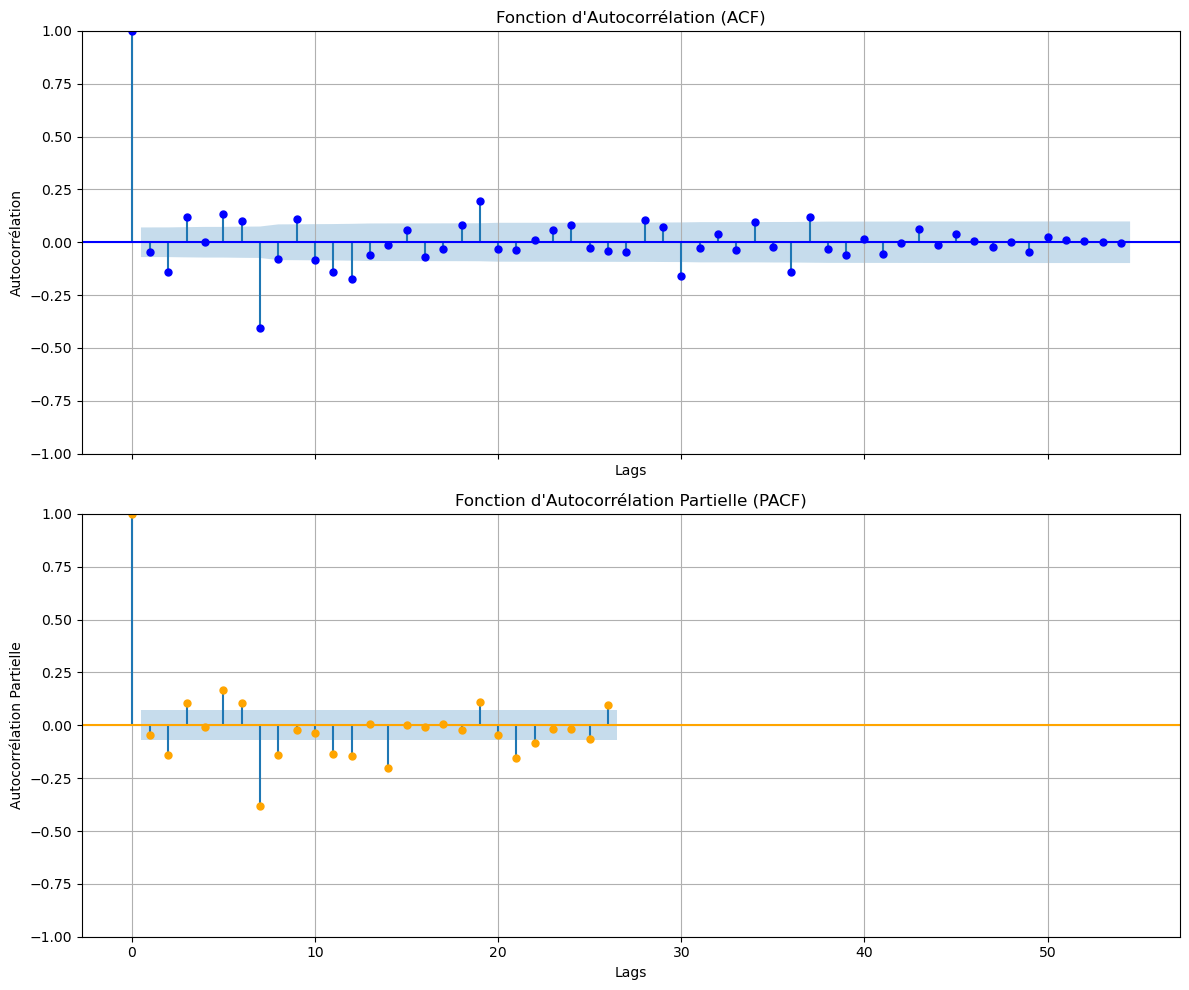

In [158]:
# Identification des Ordres (p,d,q) et saisonnalité (P,D,Q,s)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Création de la figure avec des sous-graphiques
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Graphique de l'ACF
plot_acf(y_seasonal_diff, lags=54, ax=axs[0], color='blue', alpha=0.6)
axs[0].set_title('Fonction d\'Autocorrélation (ACF)')
axs[0].set_xlabel('Lags')
axs[0].set_ylabel('Autocorrélation')
axs[0].grid(True)

# Graphique du PACF avec méthode 'ywm'
plot_pacf(y_seasonal_diff, lags=26, ax=axs[1], color='orange', alpha=0.6, method='ywm')
axs[1].set_title('Fonction d\'Autocorrélation Partielle (PACF)')
axs[1].set_xlabel('Lags')
axs[1].set_ylabel('Autocorrélation Partielle')
axs[1].grid(True)

# Ajuster la disposition
plt.tight_layout()
plt.show()

In [159]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Exemple avec des paramètres manuels
p, d, q = 0, 1, 0
P, D, Q, s = 0, 1, 0, 7

model = SARIMAX(y, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:        nb_appel_recu_file_attente   No. Observations:                   63
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood                -383.577
Date:                           Tue, 03 Sep 2024   AIC                            769.154
Time:                                   15:19:33   BIC                            771.161
Sample:                               04-29-2024   HQIC                           769.930
                                    - 06-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.676e+04   9636.925      6.927      0.000    4.79e+04    8.56e+04
Ljung-Box (L1) (Q):                  12.10 

In [160]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# Supposons que 'y' soit votre série temporelle
# y = pd.Series(...)

def cross_validate_sarima(y, train_size, p, d, q, P, D, Q, s):
    """Effectue une validation croisée en utilisant les derniers jours comme test."""
    
    # Diviser les données en ensemble d'entraînement et de test
    train = y[:-train_size]
    test = y[-train_size:]
    
    # Ajuster le modèle SARIMA
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=False)
    
    # Prédictions sur l'ensemble de test
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
    
    # Calculer l'erreur de prédiction
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    
    return rmse

# Exemple de paramètres
p, d, q = 0, 1, 0
P, D, Q, s = 0, 1, 0, 7
train_size = 7  # Utiliser les 7 derniers jours comme test

# Exécuter la validation croisée
rmse = cross_validate_sarima(y, train_size, p, d, q, P, D, Q, s)
print(f'RMSE de la validation croisée : {rmse}')

RMSE de la validation croisée : 206.26681749617396


In [161]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Spécifier les meilleurs paramètres trouvés (à ajuster selon votre modèle)
p, d, q = 0, 1, 0
P, D, Q, s = 0, 1, 0, 7

# Ajuster le modèle SARIMA
model = SARIMAX(gp_train['nb_appel_recu_file_attente'], 
                 order=(p, d, q), 
                 seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)

# Faire des prévisions pour les 7 jours suivants
forecast_steps = 7
forecast = model_fit.get_forecast(steps=forecast_steps)

# Créer un index de dates pour les prévisions
forecast_index = pd.date_range(start=gp_train.index[-1] + pd.DateOffset(days=1), 
                               periods=forecast_steps, freq='D')

# Créer un DataFrame avec les prévisions et les intervalles de confiance
forecast_df = pd.DataFrame({
    'forecast': forecast.predicted_mean,
    'conf_int_lower': forecast.conf_int()['lower nb_appel_recu_file_attente'],
    'conf_int_upper': forecast.conf_int()['upper nb_appel_recu_file_attente']
}, index=forecast_index)

# Afficher les prévisions
print(forecast_df)

            forecast  conf_int_lower  conf_int_upper
2024-06-24     885.0      397.353399     1372.646601
2024-06-25     816.0      126.363563     1505.636437
2024-06-26     854.0        9.371311     1698.628689
2024-06-27    1056.0       80.706798     2031.293202
2024-06-28     894.0     -196.410949     1984.410949
2024-06-29     833.0     -361.485347     2027.485347
2024-06-30     319.0     -971.191634     1609.191634


In [162]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fonction pour faire des prévisions pour un certain nombre de jours
def forecast_future(model_fit, forecast_steps, start_date):
    # Créer des prévisions
    forecast = model_fit.get_forecast(steps=forecast_steps)
    
    # Créer un index de dates pour les prévisions
    forecast_index = pd.date_range(start=start_date, periods=forecast_steps, freq='D')
    
    # Créer un DataFrame avec les prévisions et les intervalles de confiance
    forecast_df = pd.DataFrame({
        'forecast': forecast.predicted_mean,
        'conf_int_lower': forecast.conf_int().iloc[:, 0],  # Correction ici
        'conf_int_upper': forecast.conf_int().iloc[:, 1]   # Correction ici
    }, index=forecast_index)
    
    return forecast_df

# Ajuster le modèle SARIMA avec les meilleurs paramètres trouvés
p, d, q = 0, 1, 0
P, D, Q, s = 0, 1, 0, 7

# Ajuster le modèle SARIMA
model = SARIMAX(gp_train['nb_appel_recu_file_attente'], 
                 order=(p, d, q), 
                 seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)

# Première prévision pour les 7 jours suivants
forecast_steps = 7
last_date = gp_train.index[-1] + pd.DateOffset(days=1)
first_forecast_df = forecast_future(model_fit, forecast_steps, start_date=last_date)

# Utiliser les prévisions comme nouvelle série pour prévoir la semaine suivante
# Créer un DataFrame des prévisions comme nouvelle série temporelle
extended_series = pd.concat([gp_train['nb_appel_recu_file_attente'], first_forecast_df['forecast']])

# Réajuster le modèle avec les nouvelles données
model_updated = SARIMAX(extended_series, 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, s))
model_fit_updated = model_updated.fit(disp=False)

# Prévoir les 7 jours suivants après les prévisions initiales
second_forecast_df = forecast_future(model_fit_updated, forecast_steps, start_date=first_forecast_df.index[-1] + pd.DateOffset(days=1))

# Afficher les prévisions
print("Prévisions pour les 7 jours suivants:")
print(first_forecast_df)

print("\nPrévisions pour les 7 jours suivants après les prévisions initiales:")
print(second_forecast_df)

Prévisions pour les 7 jours suivants:
            forecast  conf_int_lower  conf_int_upper
2024-06-24     885.0      397.353399     1372.646601
2024-06-25     816.0      126.363563     1505.636437
2024-06-26     854.0        9.371311     1698.628689
2024-06-27    1056.0       80.706798     2031.293202
2024-06-28     894.0     -196.410949     1984.410949
2024-06-29     833.0     -361.485347     2027.485347
2024-06-30     319.0     -971.191634     1609.191634

Prévisions pour les 7 jours suivants après les prévisions initiales:
            forecast  conf_int_lower  conf_int_upper
2024-07-01     874.0      418.224857     1329.775143
2024-07-02     805.0      160.436611     1449.563389
2024-07-03     843.0       53.574295     1632.425705
2024-07-04    1045.0      133.449714     1956.550286
2024-07-05     883.0     -136.144202     1902.144202
2024-07-06     822.0     -294.416538     1938.416538
2024-07-07     308.0     -897.867682     1513.867682


In [163]:
first_forecast_df['day'] = first_forecast_df.index.day_name()
second_forecast_df['day'] = second_forecast_df.index.day_name()

In [164]:
first_forecast_df = first_forecast_df.set_index('day')
first_forecast_df

,forecast,conf_int_lower,conf_int_upper
day,,,
Monday,885.0,397.353399,1372.646601
Tuesday,816.0,126.363563,1505.636437
Wednesday,854.0,9.371311,1698.628689
Thursday,1056.0,80.706798,2031.293202
Friday,894.0,-196.410949,1984.410949
Saturday,833.0,-361.485347,2027.485347
Sunday,319.0,-971.191634,1609.191634


In [165]:
first_forecast_df = first_forecast_df['forecast']

In [166]:
second_forecast_df = second_forecast_df.set_index('day')
second_forecast_df

,forecast,conf_int_lower,conf_int_upper
day,,,
Monday,874.0,418.224857,1329.775143
Tuesday,805.0,160.436611,1449.563389
Wednesday,843.0,53.574295,1632.425705
Thursday,1045.0,133.449714,1956.550286
Friday,883.0,-136.144202,1902.144202
Saturday,822.0,-294.416538,1938.416538
Sunday,308.0,-897.867682,1513.867682


In [167]:
second_forecast_df = second_forecast_df['forecast']

In [172]:
predictions = (second_forecast_df + first_forecast_df)/2
predictions

day
Monday        879.5
Tuesday       810.5
Wednesday     848.5
Thursday     1050.5
Friday        888.5
Saturday      827.5
Sunday        313.5
Name: forecast, dtype: float64

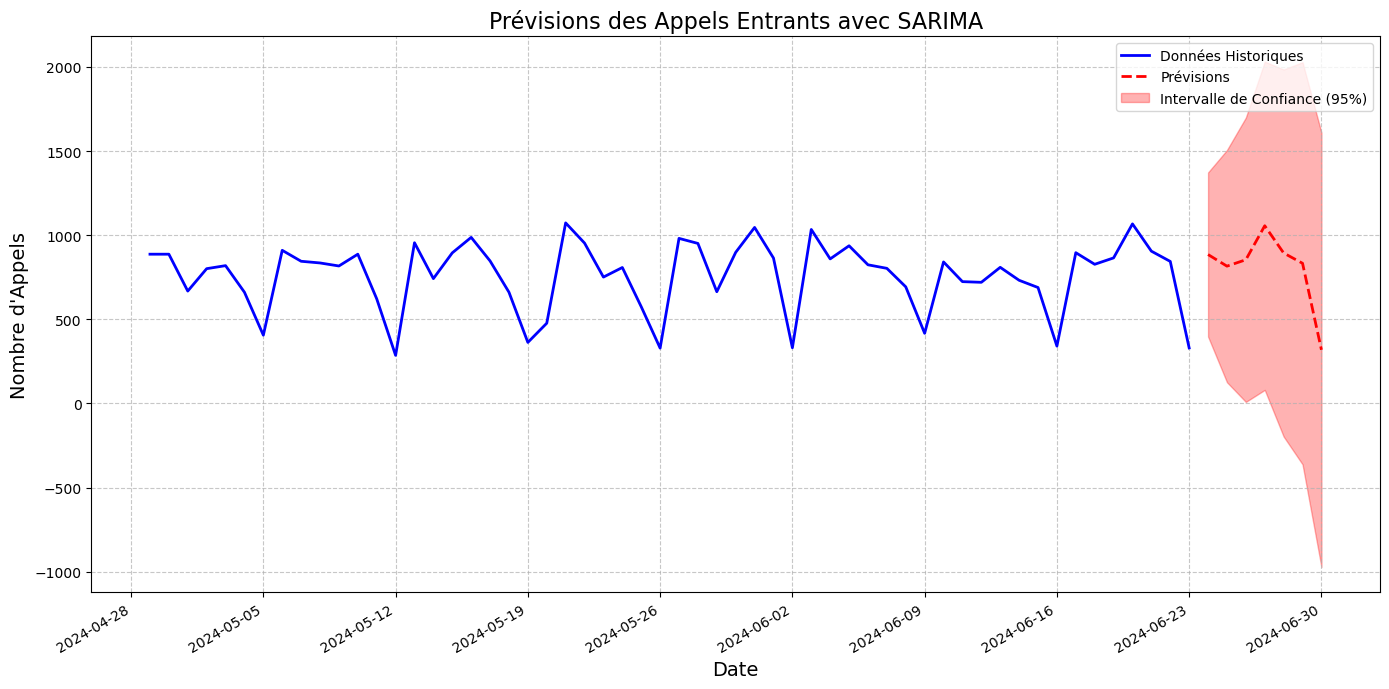

In [173]:
plt.figure(figsize=(14, 7))

# Tracer les données historiques avec une ligne bleue continue
plt.plot(gp_train.index, gp_train['nb_appel_recu_file_attente'], 
         label='Données Historiques', color='blue', linestyle='-', linewidth=2)

# Tracer les prévisions avec une ligne rouge discontinue
plt.plot(forecast_df.index, forecast_df['forecast'], 
         label='Prévisions', color='red', linestyle='--', linewidth=2)

# Tracer les intervalles de confiance avec une couleur rouge semi-transparente
plt.fill_between(forecast_df.index, 
                 forecast_df['conf_int_lower'], 
                 forecast_df['conf_int_upper'], 
                 color='red', alpha=0.3, label='Intervalle de Confiance (95%)')

# Ajouter des labels, un titre et une légende
plt.xlabel('Date', fontsize=14)
plt.ylabel('Nombre d\'Appels', fontsize=14)
plt.title('Prévisions des Appels Entrants avec SARIMA', fontsize=16)
plt.legend()

# Ajouter une grille pour faciliter la lecture
plt.grid(True, linestyle='--', alpha=0.7)

# Améliorer l'affichage des dates sur l'axe des x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))
plt.gcf().autofmt_xdate()  # Rotation des dates pour une meilleure lisibilité

# Afficher le graphique
plt.tight_layout()  # Ajuster automatiquement les marges
plt.show()